In [1]:
import findspark
findspark.init()
import pyspark as spark
from pyspark.sql.functions import udf
import pyspark.sql.functions as F
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from hsbmpy import get_max_available_L

/home/fvalle/anaconda3/envs/phd/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/home/fvalle/anaconda3/envs/phd/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
sc = spark.SparkContext()
sql = spark.SQLContext(sc)

In [142]:
label='primary_site'
labels = ['primary_site', 'disease_type', 'disease_tissue']
#labels = ['primary_site', 'secondary_site']
algorithm = 'topsbm-overlap'
#labels = ['primary_site', 'secondary_site', 'status']
#labels=['RPPA Clusters']
directory = "/home/fvalle/phd/datasets/breast/"
#directory = "/home/fvalle/phd/results/altmann"
#directory = "/Users/filippo/Google Drive File Stream/My Drive/tesi_magistrale/tesi/results/hSBM/highlyvariable_7tissues"
L=get_max_available_L(directory, algorithm)
L=0
os.chdir(directory)

In [198]:
df_Pwt = sql.read.option('header',True).csv("%s/%s/%s_level_%d_word-dist.csv"%(directory,algorithm,algorithm,L))

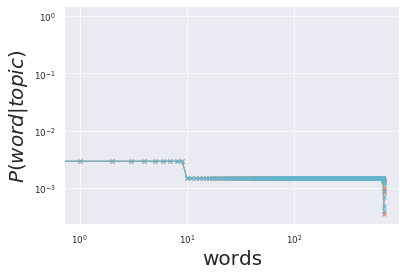

In [146]:
fig=plt.figure()
plt.title("")
for topic in df_Pwt.columns[:]:
    dist = df_Pwt.select([topic]).filter(F.col(topic)>1e-50).sort([topic], ascending=False).toPandas().astype(float).values
    if len(dist)<2:
        pass
    plt.plot(np.sort(dist[dist>0].T)[::-1], marker='x', label=topic)
plt.ylabel("$P(word | topic$)", fontsize=20)
plt.xlabel("words", fontsize=20)
plt.xscale('log')
plt.yscale('log')
#plt.legend()
plt.show()

In [147]:
df_Ptd = sql.read.option('header',True).csv("%s/%s/%s_level_%d_topic-dist.csv"%(directory,algorithm,algorithm,L)).drop('i_doc')

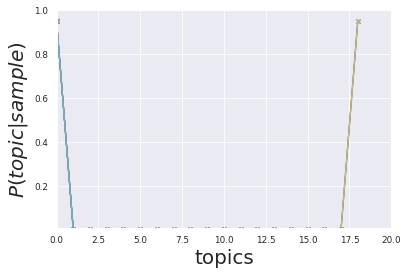

In [152]:
plt.figure()
plt.ylabel("$P(topic | sample$)", fontsize=20)
plt.xlabel("topics", fontsize=20)
for sample in df_Ptd.select('doc').toPandas().values[:10]:
    plt.plot(df_Ptd.filter(F.col('doc')==sample[0]).drop('doc').toPandas().astype(float).values[0], marker='x')
    #plt.plot(np.sort(df_Ptd.filter(F.col('doc')==sample[0]).drop('doc').toPandas().astype(float).values[0])[::-1], lw=0.1, marker='x')
#plt.plot(np.logspace(0,2),1/np.logspace(0,2))
#plt.xscale('log')
#plt.yscale('log')
plt.ylim(1e-2,1)
plt.xlim(0,20)
plt.show()

In [153]:
import tensorflow as tf

In [154]:
Pgt = tf.convert_to_tensor(df_Pwt.toPandas().set_index('_c0').astype(float).values)
Pts = tf.transpose(tf.convert_to_tensor(df_Ptd.toPandas().set_index('doc').astype(float).values))

In [155]:
Pgt

<tf.Tensor 'Const_4:0' shape=(699, 19) dtype=float64>

In [156]:
Pts

<tf.Tensor 'transpose_2:0' shape=(19, 36) dtype=float64>

In [157]:
with tf.Session() as sess:
    Pgs = sess.run(tf.matmul(Pgt,Pts))
Pgs.shape

(699, 36)

In [158]:
df_Pgs = pd.DataFrame(data=Pgs, index=df_Pwt.toPandas().values.T[0], columns=df_Ptd.select(['doc']).toPandas().values.T[0])

In [159]:
A=np.genfromtxt("A.dat")

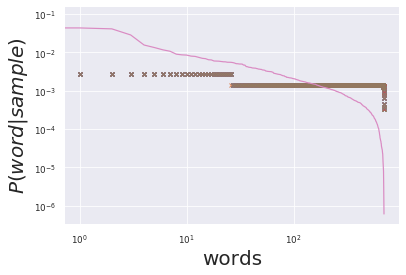

In [160]:
fig=plt.figure()
for doc in df_Pgs.columns[:200]:
    #doc = df_Pgs.columns[0]
    cdf = df_Pgs[doc]
    s_values = cdf[cdf>1e-95].sort_values(ascending=False)
    s_values = s_values/np.sum(s_values)
    plt.plot(s_values.values, marker='x', lw=0)
plt.plot(np.sort(A)[::-1]/A.sum())
plt.ylabel("$P(word | sample$)", fontsize=20)
plt.xlabel("words", fontsize=20)
plt.xscale('log')
plt.yscale('log')
plt.show()

In [73]:
A_hsbm = df_Pgs.apply(lambda x: np.average(x), axis=1)

In [20]:
def get_tissue(sample, samples=None):
    for fullsample in samples.index.values:
        if sample in fullsample:
            return samples.loc[fullsample,:]

In [21]:
df_file=pd.read_csv("%s/files.dat"%directory, index_col=0)

/home/fvalle/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


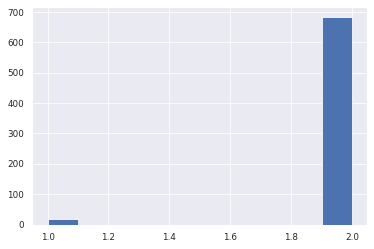

In [199]:
df_Pwt.toPandas().set_index('_c0').astype(float).apply(lambda x: len(np.nonzero(x)[0]), axis=1).hist()

_c0
ENSG00000005075    2
ENSG00000005156    2
ENSG00000006327    2
ENSG00000006459    2
ENSG00000006576    2
                  ..
ENSG00000259384    2
ENSG00000261052    2
ENSG00000269190    2
ENSG00000271303    1
ENSG00000272899    2
Length: 699, dtype: int64

In [238]:
df_Pwt_pandas = df_Pwt.toPandas().set_index('_c0')

In [239]:
df_Pwt_pandas.insert(0,'overlap',df_Pwt.toPandas().set_index('_c0').astype(float).apply(lambda x: len(np.nonzero(x)[0]), axis=1).values)

In [243]:
for g in df_Pwt_pandas[df_Pwt_pandas['overlap']==1].index:
    print(g)

ENSG00000069248
ENSG00000092098
ENSG00000100532
ENSG00000104738
ENSG00000115541
ENSG00000130176
ENSG00000133027
ENSG00000135622
ENSG00000140987
ENSG00000145388
ENSG00000162032
ENSG00000165609
ENSG00000166938
ENSG00000204394
ENSG00000242498
ENSG00000253305
ENSG00000271303
